In [1]:
#imorting dependencies
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy.physics.quantum.dagger import Dagger


In [14]:
class variables:
    def __init__(self):
        self.gen_variables()
        self.gen_H()
        self.H_scaled = self.normalize(self.H) #here we decide which hamiltonian will get generated
        self.G_scaled = self.normalize(self.G)
        
    def gen_variables(self):   
        self.E_c    = sp.Symbol("E_c")
        self.E_b    = sp.Symbol("E_b")
        self.E_a    = sp.Symbol("E_a")

        self.h      = sp.Symbol("h")
        self.Om_cb  = sp.Symbol("\Omega_{cb}")
        self.Om_ba  = sp.Symbol("\Omega_{ba}")
        self.V_cb   = self.h*self.Om_cb/2
        self.V_ba   = self.h*self.Om_ba/2
        self.om_cb  = sp.Symbol("\omega_{L'}")
        self.om_ba  = sp.Symbol("\omega_{L}")
        self.I      = sp.Symbol("I")
        self.t      = sp.Symbol("t")
        self.e_cb_lower   = sp.exp(self.I*self.om_cb*self.t)
        self.e_cb_upper   = sp.exp(-self.I*self.om_cb*self.t)
        self.e_ba_lower   = sp.exp(self.I*self.om_ba*self.t)
        self.e_ba_upper   = sp.exp(-self.I*self.om_ba*self.t)
        
        self.d_cb   = sp.Symbol("\delta_{CB}")
        self.d_ba   = sp.Symbol("\delta_{BA}")
        
        self.n_3_   = self.h*self.om_cb/2
        self.n_8_   = (self.h/sp.sqrt(3))*(self.om_ba+self.om_cb/2)

        self.values = [(self.E_c,5/3),(self.E_b,2/3),(self.E_a,-(7/3)),(self.h,1),(self.d_cb,0),(self.d_ba,0),(self.Om_cb,0.05),(self.Om_ba,0.2),(self.om_cb,1.1),(self.om_ba,3),(self.I,1j)]
        
    def gen_H(self):
        self.H_A =sp.Matrix([
            [self.E_c,0,0],
            [0,self.E_b,0],
            [0,0,self.E_a]
        ])

        self.V_1 =self.V_cb*sp.Matrix([
            [0,              self.e_cb_upper,0],
            [self.e_cb_lower,0              ,0],
            [0,              0              ,0]
        ])
        self.V_2 =self.V_ba*sp.Matrix([
            [0, 0,                      0],
            [0,0         ,self.e_ba_upper],
            [0,self.e_ba_lower         ,0]
        ])
        
        self.lambda_3 = sp.Matrix([
            [1, 0, 0],
            [0,-1 ,0],
            [0, 0 ,0]
        ])
        self.lambda_8 = (1/sp.sqrt(3))*sp.Matrix([
            [1, 0 , 0],
            [0, 1 , 0],
            [0, 0 ,-2]
        ])
        self.lambda_1 = sp.Matrix([
            [0, 1 , 0],
            [1, 0 , 0],
            [0, 0 , 0]
        ])
        self.lambda_6 = sp.Matrix([
            [0, 0 , 0],
            [0, 0 , 1],
            [0, 1 , 0]
        ])
        self.G = (self.n_3_*self.lambda_3 + self.n_8_*self.lambda_8)
        self.H = (self.d_cb*self.lambda_3 + (1/sp.sqrt(3))*(2*self.d_ba+self.d_cb)*self.lambda_8+self.Om_cb*self.lambda_1+self.Om_ba*self.lambda_6)
    def Trace(self,H):
        s=0
        for i in range(H.shape[0]):
            s+=H[i,i]
        return s
    def normalize(self,H): #normalizing some input hamiltonian
        a=self.Trace(H*H)
        scale = sp.sqrt(a/2)
        H_scaled = H/scale
        return H_scaled

In [3]:

class SU_3:
    def __init__(self): #only valid for 3 dim
        #following is valid if the determinant of the generator does not vary
        #self.phi = self.det_to_phi(sp.det(H_sample))
        #generating coefficients:
        #self.C_1,self.C_2,self.C_3 = self.gen_coefficients(self.phi)
        #one extra thing: the unitary matrix:
        self.Identity =  sp.eye(3)
        
    def det_to_phi(self,H_det):
        phi  = sp.Symbol("\phi")
        res  = sp.solvers.solve((2/(3*sp.sqrt(3)))*sp.sin(3*phi)+H_det,phi)
        return min(res)
    
    def outside_brackets(self,phi,k): # used in self.gen_coefficients(phi)
        out_bra_u = (sp.exp((2/sp.sqrt(3))*1j*sp.Symbol("t")*(sp.sin(phi+(2*sp.pi*k)/3)))).evalf()
        out_bra_l = (1 - 2*sp.cos(2*(phi+(2*sp.pi*k)/3))).evalf()
        out_bra   = out_bra_u/out_bra_l
        return out_bra     
    
    def gen_coefficients(self,phi):
        C_1,C_2,C_3 = 0,0,0
        for k in range(3):
            out_bra = self.outside_brackets(phi,k)
            C_1+=out_bra
            C_2+=(2/sp.sqrt(3))*(sp.sin(phi+(2*sp.pi*k)/3))*out_bra
            C_3+=-(1/3)*(1+2*sp.cos(2*(phi+(2*sp.pi*k)/3)))*out_bra #sp.eye((self.H).shape[0])
        return C_1.evalf(),C_2.evalf(),C_3.evalf()

    def gen_unitary_m(self,H): #input H/h must be evaluated already (no t dependence)
        phi = self.det_to_phi(sp.det(H))
        C_1,C_2,C_3 = self.gen_coefficients(phi)
        return H*H*C_1+H*C_2+self.Identity*C_3




In [4]:
import matplotlib.pyplot as plt
class m_vectors:
    def __init__(self,RHO_EVOL):
        self.RHO_EVOL = RHO_EVOL
        self.gen_rho_el()
        self.m_l = self.gen_m()
    def gen_rho_el(self):
        self.rho_l =[
            [],
            [],
            [],
            [],
            [],
            [],
            [],
            [],
            [],
        ]
        for mat in self.RHO_EVOL:
            self.rho_l[0].append(complex(mat[0][0]))
            self.rho_l[1].append(complex(mat[0][1]))
            self.rho_l[2].append(complex(mat[0][2]))
            self.rho_l[3].append(complex(mat[1][0]))
            self.rho_l[4].append(complex(mat[1][1]))
            self.rho_l[5].append(complex(mat[1][2]))
            self.rho_l[6].append(complex(mat[2][0]))
            self.rho_l[7].append(complex(mat[2][1]))
            self.rho_l[8].append(complex(mat[2][2]))
        self.rho_l = [np.array(el) for el in self.rho_l]
    def gen_m(self):
        arr = []
        arr.append(np.sqrt(3)*np.real(self.rho_l[1]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l[1]))
        arr.append((1/(2*np.sqrt(3)))*np.real(self.rho_l[0]-self.rho_l[4]))
        arr.append(np.sqrt(3)*np.real(self.rho_l[2]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l[2]))
        arr.append(np.sqrt(3)*np.real(self.rho_l[5]))
        arr.append(np.sqrt(3)*np.imag(self.rho_l[5]))
        arr.append((1/2)*(1-3*np.real(self.rho_l[8])))
        return arr

In [12]:
class plotting_m:
    def __init__(self,m_l):
        self.m_l = m_l

    def plot_cartan(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[2],self.m_l[7],'g:')
        plt.plot([-1./(2*np.sqrt(3)),1./(2*np.sqrt(3))],[1/2,1/2],'b')
        plt.plot([0,-1/(2*np.sqrt(3))],[-1,1/2],'b')
        plt.plot([0,1/(2*np.sqrt(3))],[-1,1/2],'b')
        plt.text(1./(2*np.sqrt(3))+0.01, 1/2, 'state C', fontsize=12)
        plt.text(-1./(2*np.sqrt(3))-0.14, 1/2, 'state B', fontsize=12)
        plt.text(-0.045, -1-0.1, 'state A', fontsize=12)
        D = 0 #the displacement size of the plot
        plt.axis([-1/2-D, 1/2+D, -1.2-D, 2/3+D])
        plt.xlabel("m_3",fontsize=16)
        plt.ylabel("m_8",fontsize=16)
        plt.title("Evolution of a 3-level quantum system",fontsize=16)
        plt.show()
    def plot_1_2(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[0],self.m_l[1],'g:')
        plt.axis([-2, 2, -2, 2])
        """plt.plot([-1./(2*np.sqrt(3)),1./(2*np.sqrt(3))],[1/2,1/2],'b')
        plt.plot([0,-1/(2*np.sqrt(3))],[-1,1/2],'b')
        plt.plot([0,1/(2*np.sqrt(3))],[-1,1/2],'b')
        plt.text(1./(2*np.sqrt(3))+0.01, 1/2, 'state C', fontsize=12)
        plt.text(-1./(2*np.sqrt(3))-0.14, 1/2, 'state B', fontsize=12)
        plt.text(-0.045, -1-0.1, 'state A', fontsize=12)
        D = 0.0 #the displacement size of the plot
        
        plt.xlabel("m_3",fontsize=16)
        plt.ylabel("m_8",fontsize=16)
        plt.title("Evolution of a 3-level quantum system",fontsize=16)"""
        plt.show()
    def plot_4_5(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[3],self.m_l[4],'g:')
        plt.axis([-2, 2, -2, 2])
        plt.show()
    def plot_6_7(self):
        plt.figure(figsize=[10, 10])
        plt.plot(self.m_l[5],self.m_l[6],'g:')
        plt.axis([-2, 2, -2, 2])
        plt.show()


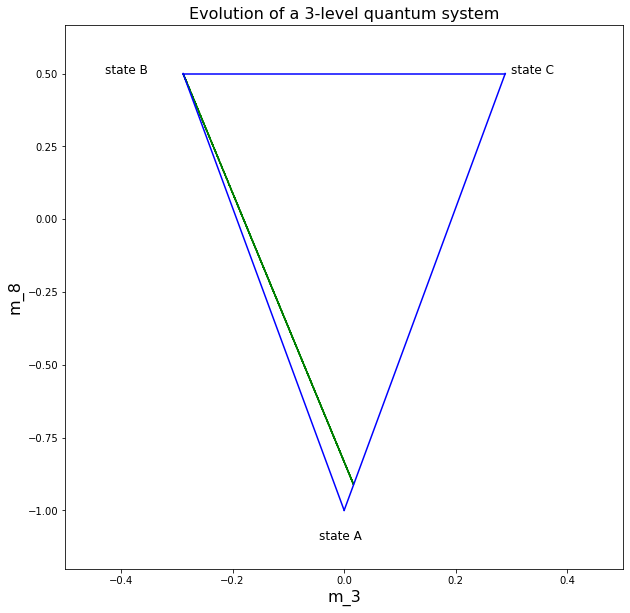

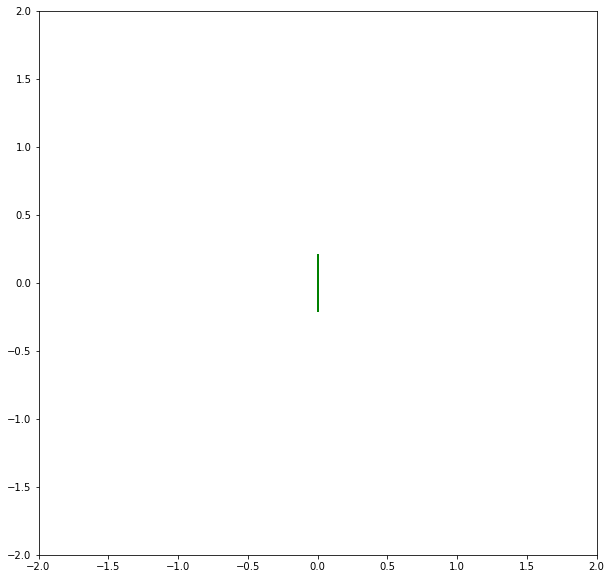

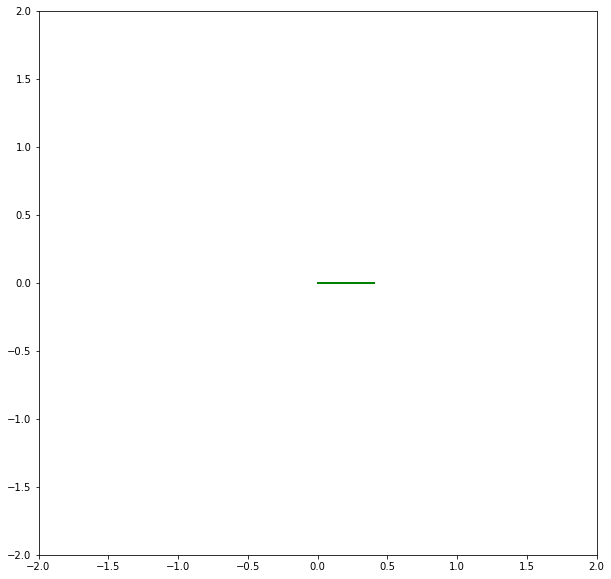

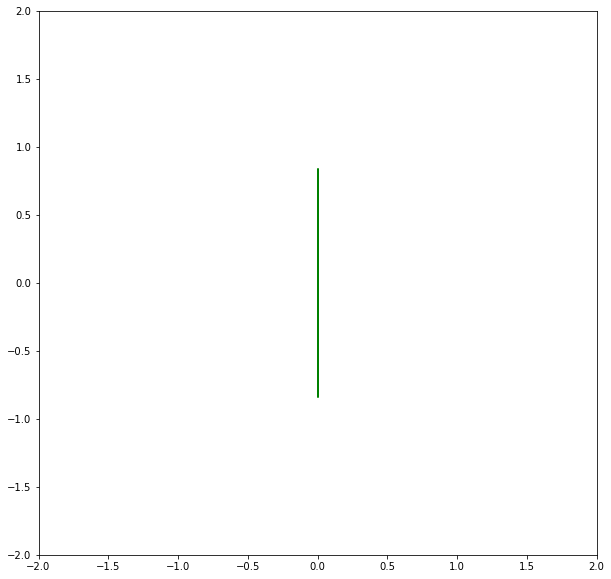

In [15]:
def gen_rho_0():
    rho = sp.Matrix([
        [0,0,0],
        [0,1,0],
        [0,0,0]
    ])
    return rho

def transform2(U,T):
    U_dagg = Dagger(U)
    T_dagg = Dagger(T)
    rho_evol = T_dagg*U*rho*U_dagg*T
    return np.array(rho_evol)

def transform(U):
    U_dagg = Dagger(U)
    rho_evol = U*rho*U_dagg
    return np.array(rho_evol)

def run():
    objects = variables()
    H_scaled = objects.H_scaled.subs(objects.values)
    G_scaled = objects.G_scaled.subs(objects.values)
    
    
    matrix_to_unitary = SU_3()
    U = matrix_to_unitary.gen_unitary_m(H_scaled)
    T = matrix_to_unitary.gen_unitary_m(G_scaled)
    
    U_fun =  lambdify(sp.Symbol("t"),U)
    T_fun =  lambdify(sp.Symbol("t"),T)
    
    
    t = np.linspace(0,12,100)
    U_list  = [sp.Matrix(U_fun(t_)) for t_ in t]
    T_list  = [sp.Matrix(T_fun(t_)) for t_ in t]
    
    #generates the evolution of rho:
    #rho = gen_rho_0()
    #RHO_EVOL = list(map(transform2,U_list,T_list))
    RHO_EVOL = list(map(transform,U_list))
    
    #for plotting
    m_inst = m_vectors(RHO_EVOL)
    m_l = m_inst.m_l
    plotting = plotting_m(m_l)
    plotting.plot_cartan()
    plotting.plot_1_2()
    plotting.plot_4_5()
    plotting.plot_6_7()
rho = gen_rho_0()
run()

In [50]:
objects = variables()
H_scaled = objects.G_scaled
#H_A_scaled = H_scaled.subs(objects.values)
H_scaled = H_scaled.subs(objects.values)
H_scaled
#H_A_scaled_intg = sp.integrate(H_A_scaled,(sp.Symbol("t"),0,sp.Symbol("t^{'}")))
#print("this value must be time independent")
#print(sp.det(H_A_scaled))
#sp.det(H_A_scaled_intg)


Matrix([
[0.816798707332489,                 0,                 0],
[                0, 0.298445681525332,                 0],
[                0,                 0, -1.11524438885782]])

In [51]:
#creating the instance with which we generate the unitary matrix

H_to_U=SU_3()
U = H_to_U.gen_unitary_m(H_scaled)
U_fun =  lambdify(sp.Symbol("t"),U)

#H_A_scaled_intg_fun = lambdify(sp.Symbol("t"),H_scaled)

t = np.linspace(0,10,100)
U_list  = [U_fun(t_) for t_ in t]

In [62]:
rho = np.array([
    [0,1,0],
    [1,0,0],
    [0,0,0]
])
def transform(U):
    U_dagg = Dagger(U)
    rho_evol = U*rho*U_dagg
    return np.array(rho_evol)
RHO_EVOL = list(map(transform,U_list))
u = U_list[10]
u_dagg = Dagger(u)
print(rho)
print(u)

[[0 1 0]
 [1 0 0]
 [0 0 0]]
[[0.67852083+0.73458117j 0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.95490393+0.29691495j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.42981407-0.90291742j]]


In [11]:

m_inst = m_vectors(RHO_EVOL)

m_l = m_inst.m_l

plotting_m()